In [1]:
import os
import copy
from dataclasses import dataclass

import numpy as np
import torch
from datasets import Dataset, load_dataset
from transformers import (
    BitsAndBytesConfig,
    Gemma2ForSequenceClassification,
    GemmaTokenizerFast,
    Gemma2Config,
    PreTrainedTokenizerBase, 
    EvalPrediction,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType
from sklearn.metrics import log_loss, accuracy_score
from transformers.integrations import TensorBoardCallback

In [2]:
# parameters here for training and lora config 
class Config:
    output_dir: str = "output"
    checkpoint: str = "unsloth/gemma-2-9b-it-bnb-4bit"  # 4-bit quantized gemma-2-9b-instruct
    max_length: int = 1024
    n_splits: int = 5
    fold_idx: int = 0
    optim_type: str = "adamw_8bit"
    per_device_train_batch_size: int = 2
    gradient_accumulation_steps: int = 2  # global batch size is 8 
    per_device_eval_batch_size: int = 8
    n_epochs: int = 1
    freeze_layers: int = 16  # there're 42 layers in total, we don't add adapters to the first 16 layers
    lr: float = 2e-4
    warmup_steps: int = 20
    lora_r: int = 16
    lora_alpha: float = lora_r * 2
    lora_dropout: float = 0.05
    lora_bias: str = "none"
    
config = Config()

In [3]:
lora_config = LoraConfig(
    r=config.lora_r,
    lora_alpha=config.lora_alpha,
    # only target self-attention
    target_modules=["q_proj", "k_proj", "v_proj"],
    layers_to_transform=[i for i in range(42) if i >= config.freeze_layers],
    lora_dropout=config.lora_dropout,
    bias=config.lora_bias,
    task_type=TaskType.SEQ_CLS,
)

In [4]:
# instantiate tokenizer and model 
tokenizer = GemmaTokenizerFast.from_pretrained(config.checkpoint)
tokenizer.add_eos_token = True  # We'll add <eos> at the end
tokenizer.padding_side = "right"

In [5]:
model = Gemma2ForSequenceClassification.from_pretrained(
    config.checkpoint,
    num_labels=3,
    torch_dtype=torch.float16,
    device_map="auto",
)
model.config.use_cache = False
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)
model

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
Some weights of Gemma2ForSequenceClassification were not initialized from the model checkpoint at unsloth/gemma-2-9b-it-bnb-4bit and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): Gemma2ForSequenceClassification(
      (model): Gemma2Model(
        (embed_tokens): Embedding(256000, 3584, padding_idx=0)
        (layers): ModuleList(
          (0-15): 16 x Gemma2DecoderLayer(
            (self_attn): Gemma2Attention(
              (q_proj): Linear4bit(in_features=3584, out_features=4096, bias=False)
              (k_proj): Linear4bit(in_features=3584, out_features=2048, bias=False)
              (v_proj): Linear4bit(in_features=3584, out_features=2048, bias=False)
              (o_proj): Linear4bit(in_features=4096, out_features=3584, bias=False)
              (rotary_emb): Gemma2RotaryEmbedding()
            )
            (mlp): Gemma2MLP(
              (gate_proj): Linear4bit(in_features=3584, out_features=14336, bias=False)
              (up_proj): Linear4bit(in_features=3584, out_features=14336, bias=False)
              (down_proj): Linear4bit(in_features=14336, out_features=3584, bia

In [6]:
model.print_trainable_parameters()

trainable params: 7,891,456 || all params: 9,249,608,192 || trainable%: 0.0853


In [7]:
dataset = load_dataset("lmsys/lmsys-arena-human-preference-55k")
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b', 'winner_model_a', 'winner_model_b', 'winner_tie'],
        num_rows: 57477
    })
})

In [8]:
dataset = dataset['train']

In [9]:
class CustomTokenizer:
    def __init__(
        self, 
        tokenizer: PreTrainedTokenizerBase, 
        max_length: int
    ) -> None:
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __call__(self, batch: dict) -> dict:
        prompt = ["<prompt>: " + self.process_text(t) for t in batch["prompt"]]
        response_a = ["\n\n<response_a>: " + self.process_text(t) for t in batch["response_a"]]
        response_b = ["\n\n<response_b>: " + self.process_text(t) for t in batch["response_b"]]
        texts = [p + r_a + r_b for p, r_a, r_b in zip(prompt, response_a, response_b)]
        tokenized = self.tokenizer(texts, max_length=self.max_length, truncation=True)
        labels=[]
        for a_win, b_win in zip(batch["winner_model_a"], batch["winner_model_b"]):
            if a_win:
                label = 0
            elif b_win:
                label = 1
            else:
                label = 2
            labels.append(label)
        return {**tokenized, "labels": labels}
        
    @staticmethod
    def process_text(text: str) -> str:
        return " ".join(eval(text, {"null": ""}))

In [10]:
encode = CustomTokenizer(tokenizer, max_length=config.max_length)
dataset = dataset.map(encode, batched=True)

Map:   0%|          | 0/57477 [00:00<?, ? examples/s]

<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequen

In [11]:
def compute_metrics(eval_preds: EvalPrediction) -> dict:
    preds = eval_preds.predictions
    labels = eval_preds.label_ids
    probs = torch.from_numpy(preds).float().softmax(-1).numpy()
    loss = log_loss(y_true=labels, y_pred=probs)
    acc = accuracy_score(y_true=labels, y_pred=preds.argmax(-1))
    return {"acc": acc, "log_loss": loss}

In [12]:
folds = [
    (
        [i for i in range(len(dataset)) if i % config.n_splits != fold_idx],
        [i for i in range(len(dataset)) if i % config.n_splits == fold_idx]
    ) 
    for fold_idx in range(config.n_splits)
]

In [13]:
train_idx, eval_idx = folds[config.fold_idx]

In [14]:
print(len(train_idx))
print(len(eval_idx))
eval_dataset=dataset.select(eval_idx)
# Convert to pandas DataFrame first
eval_dataframe = eval_dataset.to_pandas()

# Now call head() to view the first few rows
eval_dataframe.head()

45981
11496


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,input_ids,attention_mask,labels
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,"[2, 235322, 39038, 78880, 2125, 665, 89397, 18...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
1,292873,vicuna-13b,gpt-4-0314,"[""Construct a rap battle, in the style of Epic...","[""[Zeus]\nYo, it's the king of the gods on the...","[""(Verse 1 - Zeus)\n\nI'm the king of the gods...",0,1,0,"[2, 235322, 39038, 78880, 58863, 476, 13483, 9...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
2,497862,vicuna-7b,guanaco-33b,"[""write a python function to upload all the fi...","[""Sure, here's a Python function that uses the...","[""Sure, here's an example function in Python t...",0,1,0,"[2, 235322, 39038, 78880, 5598, 476, 17706, 14...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
3,863398,llama2-70b-steerlm-chat,gemini-pro-dev-api,"[""what do you know about real estate""]","[""Real estate refers to the land and buildings...","[""1. **Types of Real Estate:**\n * **Reside...",0,1,0,"[2, 235322, 39038, 78880, 1212, 749, 692, 1230...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
4,1256092,claude-2.1,vicuna-13b,"[""Write a python code that calculates sum of 5...","[""Here is the python code that calculates the ...","[""Here is a Python code that calculates the su...",0,0,1,"[2, 235322, 39038, 78880, 15615, 476, 17706, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2


In [15]:
training_args = TrainingArguments(
    output_dir="output",
    overwrite_output_dir=True,
    report_to="tensorboard",  # Enable reporting to TensorBoard
    num_train_epochs=config.n_epochs,
    per_device_train_batch_size=config.per_device_train_batch_size,
    gradient_accumulation_steps=config.gradient_accumulation_steps,
    per_device_eval_batch_size=config.per_device_eval_batch_size,
    logging_steps=10,  # Log every 10 steps
    logging_dir='./logs',  # Directory for TensorBoard logs
    eval_strategy="epoch",
    save_strategy="steps",
    save_steps=200,
    optim=config.optim_type,
    fp16=True,
    learning_rate=config.lr,
    warmup_steps=config.warmup_steps,
)

In [16]:
train_idx, eval_idx = folds[config.fold_idx]



trainer = Trainer(
    args=training_args, 
    model=model,
    tokenizer=tokenizer,
    train_dataset=dataset.select(train_idx),
    eval_dataset=dataset.select(eval_idx),
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    callbacks=[TensorBoardCallback()],
)
trainer.train()

/tmp/ipykernel_213979/2641435634.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
You are adding a <class 'transformers.integrations.integration_utils.TensorBoardCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
TensorBoardCallback
/home/skunk/miniconda3/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs 

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0! (when checking argument for argument target in method wrapper_CUDA_nll_loss_forward)

In [19]:
eval_dataset=dataset.select(eval_idx)
predictions = trainer.predict(eval_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)  # Get the predicted class (3-way classification)
true_labels = predictions.label_ids  # Get the true class labels

NameError: name 'confusion_matrix' is not defined

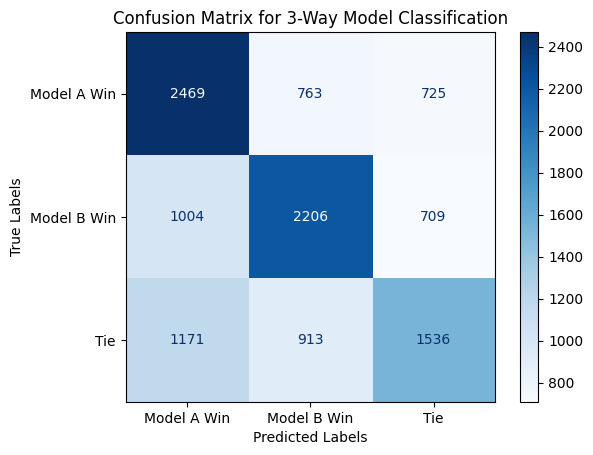

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=[0, 1, 2])

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Model A Win', 'Model B Win', 'Tie'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for 3-Way Model Classification')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()